In [1]:
import numpy as np
from ler import LeR
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [2]:
ler = LeR(min_lensed_images=2, max_lensed_images=4)

Given: IMR waveform
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
getting stored interpolator...
In case if you need regeneration of interpolator of the given gwsnr param, please delete this file, ./interpolator_pickle/halfSNR_dict_5.pickle


In [3]:
ler.batch_size = 10000
test = ler.selecting_n_lensed_detectable_events(nsamples=200, resume=False)

collected number of events =  0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1298.90it/s]


collected number of events =  96


100%|███████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1254.03it/s]


collected number of events =  182


100%|███████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1307.76it/s]


collected number of events =  274
trmming final result to size=200


In [52]:
json_file = './lensed_params_detectable.json'
with open(json_file, "r", encoding='utf-8') as f:
    param = json.load(f)

In [54]:
mu_rel0, dt_rel0, mu_rel90, dt_rel90 = \
    ler.classification_of_image(lensed_param=param, snr_threshold=[8.,8.])

In [18]:
lensed_param=param
snr_threshold=[8.,8.]

# get magnifications, time_delays and snr
mu = np.nan_to_num(lensed_param['magnifications'])
dt = np.nan_to_num(lensed_param['time_delays'])
snr = np.nan_to_num(lensed_param['opt_snr_net'])

# for 0 degree phase difference
# get the index of the image which cross the threshold
# get snr_threshold sorted first in descending order
snr_threshold = -np.sort(-np.array(snr_threshold))
# for type I
snr1 = -np.sort(-snr[:, [0, 1]], axis=1)
# for type II
snr2 = -np.sort(-snr[:, [2, 3]], axis=1)

# checking for zero values
# check for threshold condition
idx1, idx2 = [], []
for i in range(len(snr)):
    if any(x!=0. for x in snr1[i]) and snr1[i][0]>snr_threshold[0] and snr1[i][1]>snr_threshold[1]:
        idx1.append(i)
    if any(x!=0. for x in snr2[i]) and snr2[i][0]>snr_threshold[0] and snr2[i][1]>snr_threshold[1]:
        idx2.append(i)
            
            
# combine magnifications and time_delays
mu_ = np.concatenate((mu[idx1][:,[0, 1]], mu[idx2][:,[2, 3]]), axis=0)
dt_ = np.concatenate((dt[idx1][:,[0, 1]], dt[idx2][:,[2, 3]]), axis=0)/(60*60*24) # to days

# relative magnification
mu_rel0 = np.abs(mu_[:, 1]/mu_[:, 0])
# relative time delay
dt_rel0 = np.abs(dt_[:, 1]-dt_[:, 0])

# for 90 degree phase difference
# for type I
snr1 = -np.sort(-snr[:, [0, 2]], axis=1)
# for type II
snr2 = -np.sort(-snr[:, [1, 3]], axis=1)

# checking for zero values
# check for threshold condition
idx1, idx2 = [], []
for i in range(len(snr)):
    if any(x!=0. for x in snr1[i]) and snr1[i][0]>snr_threshold[0] and snr1[i][1]>snr_threshold[1]:
        idx1.append(i)
    if any(x!=0. for x in snr2[i]) and snr2[i][0]>snr_threshold[0] and snr2[i][1]>snr_threshold[1]:
            idx2.append(i)

# combine magnifications and time_delays
mu_ = np.concatenate((mu[idx1][:,[0, 2]], mu[idx2][:,[1, 3]]), axis=0)
dt_ = np.concatenate((dt[idx1][:,[0, 2]], dt[idx2][:,[1, 3]]), axis=0)/(60*60*24) # in days

# relative magnification
mu_rel90 = np.abs(mu_[:, 1]/mu_[:, 0])
# relative time delay
dt_rel90 = np.abs(dt_[:, 1]-dt_[:, 0])


In [45]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

In [48]:
dt

array([ 3142813,  2485403,   351176,  5005717, 10698075,
        3617926,  4682773,  7389651,  2658098,   546320,
        7317282,   769354,  3477162,  2037970,  5368280,
         427263,   433406,  3615633,  4451390,  2180002,
        7457342, 11040715,  2117461,   629518,  4922014,
        1275855,  7001290,  5212379,   572280,   892372,
        3105285,  2063921,  5668111,  1370952,  6239379,
        3729961,  7098716,  2270398,  4638632,  2889108,
        1300768,  9375942,  4343685,  5410214,  5620256,
        6589291,  1544777,  8672799,  4059148,  4021767,
          40331,  3876182,  8347862,  2379386,  1173614,
        5442108,  4770957,  9254711,  7126770,  2464909,
         850864,  4280306,  4413139,  4052210,   303325,
        7220215,  8720056,  5472143,  9568674,   981198,
        1319863,   476414,  3588779,  3773825,  2421198,
        5762202,  2209581,  3195803,  1770255,  7107677,
        2824587,  4488135,  3810578,   371786,  1174331,
        3972119,  2799458,  115

In [46]:
idx=(dt>1e-3) & (dt<5e2) & (dmu>1e-2) & (dmu<1e2)
xu=np.log10(dt[idx])
yu=np.log10(dmu[idx])

xmin = np.log10(1e-2)
xmax = np.log10(5e2) 
ymin = np.log10(1e-2)
ymax = np.log10(1e2) 

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([xu, yu])
kernel = gaussian_kde(values)
ff = np.reshape(kernel(positions).T, xx.shape)

zsort=-np.sort(-ff.flatten())

cumz = np.cumsum(zsort)/np.sum(zsort)
spl = interp1d(cumz, zsort)

levels = []
for i in [0.10,0.40,0.68,0.95]:
    levels.append(spl(i))
levels = np.array(levels)[::-1]

ValueError: `dataset` input should have multiple elements.

In [34]:
plt.contour(np.rot90(ff), levels, colors=colors, linestyles=linestyles, origin=origin, alpha=alpha, extent=extent)

NameError: name 'colors' is not defined

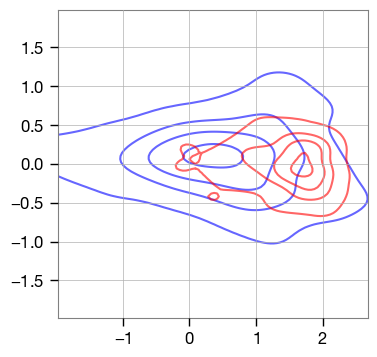

In [55]:
ler.mu_vs_dt_plot(x_array=dt_rel0, y_array=mu_rel0, ax=plt, colors='blue')
#ler.mu_vs_dt_plot(x_array=dt_rel90, y_array=mu_rel90, ax=plt)
ler.mu_vs_dt_plot(x_array=dt, y_array=dmu, ax=plt, colors='red')
#plt.xscale('log')
plt.show()

In [3]:
param = ler.selecting_n_unlensed_detectable_events(nsamples=200)

collected number of events =  0
collected number of events =  181
collected number of events =  321
trmming final result to size=200


In [5]:
param.keys()

dict_keys(['mass_1', 'mass_2', 'mass_1_source', 'mass_2_source', 'zs', 'luminosity_distance', 'iota', 'psi', 'phase', 'geocent_time', 'ra', 'dec', 'opt_snr_net', 'L1', 'H1', 'V1'])

In [8]:
t = param['geocent_time']
mu = param['luminosity_distance']

In [9]:
import random

In [49]:
len_ = len(t)
t_ = []
mu_ = []
while(len(t_)<100):
    idx1,idx2 = random.sample(range(len_),2)
    t_.append(t[idx2]-t[idx1])
    mu_.append(mu[idx2]/mu[idx1])
    
dt = np.abs(np.array(t_))/(60*60*24) # in days
dmu = np.sqrt(np.abs(np.array(mu_)))

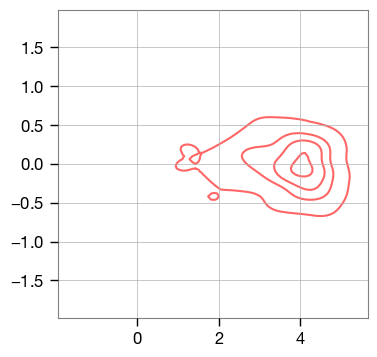

In [50]:
ler.mu_vs_dt_plot(x_array=dt, y_array=dmu, ax=plt, extent=[1e-2,5e5,1e-2,1e2], colors='red')

In [22]:
idx1

41

In [18]:
import contextlib
from ler.helperroutines import append_json

nsamples=100
snr_threshold=8.
resume=False
json_file='./gw_params_detectable.json'

try: ler.batch_size > 1000
except: ler.batch_size = 1000

if not resume:
    n = 0  # iterator
    try:
        os.remove(json_file)
    except:
        pass
else:
    # get sample size as nsamples from json file
    param_final = get_param_from_json(json_file)
    n = len(param_final['zs'])
    del param_final

buffer_file = './gw_params_buffer.json'
print('collected number of events = ', n)
while (n < nsamples):
    # disable print statements
    with contextlib.redirect_stdout(None):
        ler.unlensed_sampling_routine(nsamples=ler.batch_size,file_name=buffer_file,resume=False)

        # get unlensed params
        unlensed_param = get_param_from_json(buffer_file)

        # get snr
        snr = unlensed_param['opt_snr_net']
        # index of detectable events
        idx = snr > snr_threshold

        # store all params in json file
        for key, value in unlensed_param.items():
            unlensed_param[key] = value[idx]
        append_json(json_file, unlensed_param, replace=False)        

        n += np.sum(idx) 
    print('collected number of events = ', n)

# trim the final param dictionary
print(f"trmming final result to size={nsamples}")
param_final = get_param_from_json(json_file)
# trim the final param dictionary
idx = np.random.choice(len(param_final['zs']), nsamples, replace=False)
for key, value in param_final.items():
    param_final[key] = param_final[key][idx]

# save the final param dictionary
append_json(json_file, param_final, replace=True)

collected number of events =  0
collected number of events =  158
trmming final result to size=100


In [12]:
xxl1,yyl1,ffl1 = contfunc(dt12,dmu12)
xxl2,yyl2,ffl2 = contfunc(dt34,dmu34)

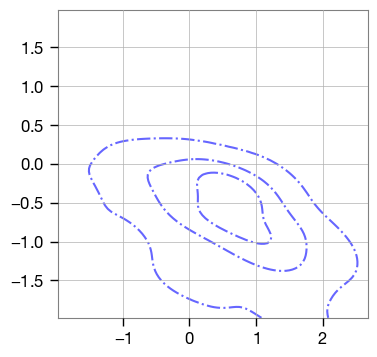

In [16]:
xmin =np.log10(1e-2) 
xmax =np.log10(5e2)  
ymin =np.log10(1e-2)    
ymax =np.log10(1e2)  
extent_im=[xmin, xmax, ymin, ymax]
levels_l=contlevs(ffl1) 

plt.contour(np.rot90(ffl2), levels_l, colors='blue', linestyles='dashdot', origin='upper', alpha=0.6, extent=extent_im)
plt.show()

In [24]:
"out_fincat_%s/all_lensprop.txt"%("O3")

'out_fincat_O3/all_lensprop.txt'

In [14]:
mu_all = test['magnifications']
snr_all = test['opt_snr_net']
dt_all = test['time_delays']

In [16]:
mu1 = []
mu2 = []
dt1 = []
dt2 = []
for i in range(len(mu_all)):
    if snr_all[i,0]>8. and snr_all[i,1]>8.:
        mu1.append(snr_all[i,0])
        mu2.append(snr_all[i,1])
        dt1.append(dt_all[i,0])
        dt2.append(dt_all[i,1])
        
mu1 = np.array(mu1)
mu2 = np.array(mu2)
dt1 = np.array(dt1)
dt2 = np.array(dt2)

# relative magnification
dmu12 = abs(mu2/mu1)
# relative time delays
dt12 = abs(dt2-dt1)

mu3 = []
mu4 = []
dt3 = []
dt4 = []
for i in range(len(mu_all)):
    if snr_all[i,2]>8. and snr_all[i,3]>8.:
        mu3.append(snr_all[i,2])
        mu4.append(snr_all[i,3])
        dt3.append(dt_all[i,2])
        dt4.append(dt_all[i,3])
        
mu3 = np.array(mu3)
mu4 = np.array(mu4)
dt3 = np.array(dt3)
dt4 = np.array(dt4)

# relative magnification
dmu34 = abs(mu4/mu3)
# relative time delays
dt34 = abs(dt4-dt3)

In [21]:
dmu1 = np.concatenate(((dmu12,dmu34))
dt1 = np.concatenate(((dt12,dt34))/(60*60*24) # to days

In [38]:
xxl1,yyl1,ffl1 = contfunc(dt_rel0,mu_rel0)

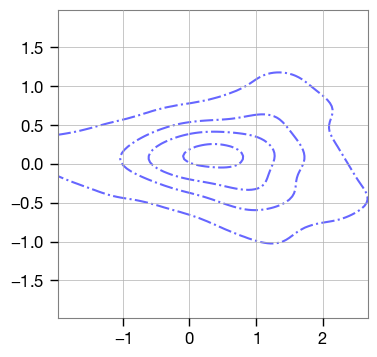

In [39]:
xmin =np.log10(1e-2) 
xmax =np.log10(5e2)  
ymin =np.log10(1e-2)    
ymax =np.log10(1e2)  
extent_im=[xmin, xmax, ymin, ymax]
levels_l=contlevs(ffl1) 

plt.contour(np.rot90(ffl1), levels_l, colors='blue', linestyles='dashdot', origin='upper', alpha=0.6, extent=extent_im)
plt.show()

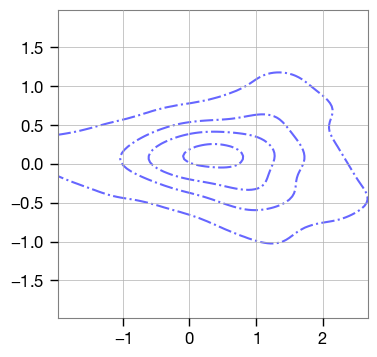

In [40]:
plt.contour(np.rot90(ff), contlevs(ff), colors='blue', linestyles='dashdot', origin='upper', alpha=0.6, extent=extent_im)
plt.show()

In [18]:
df = sns.load_dataset('iris')
 
# set seaborn style
sns.set_style("white")

# Basic 2D density plot
x = np.log10(dt1)
y = np.log(dmu1)
sns.kdeplot(x=x, y=y,legend=True, levels=1,thresh=.68)
sns.kdeplot(x=x, y=y,legend=True, levels=1,thresh=.95)
sns.kdeplot(x=x, y=y,legend=True, levels=1,thresh=.997)
#plt.xlim(-2, 3)
#plt.ylim(-2, 2)
plt.xlabel(r'$log(abs(\Delta t_{21}))\,days$')
plt.ylabel(r'$log10(\mu_2/\mu_1)$')
plt.title('relative time delay vs relative magnification \n Image type I')
plt.legend()
plt.grid()
plt.show()

NameError: name 'sns' is not defined

In [49]:
np.array([1,2,3])[::-1]

array([3, 2, 1])